# QAOA transpilation pipeline

This notebook is the entry point into the how-tos. It shows a QAOA transpilation pipeline from the user's perspective without going into the details of each step. If you are looking for code to copy and past this is a good place to start. This how-to showcases the following functionality from a high level.

* Defining a SWAP strategy to route the QAOA cost operator.
* Finding a good initial mapping with the SAT mapper.
* Selecting good qubits to work with.
* Applying a preset QAOA pass manager defined in `generate_preset_qaoa_pass_manager` to perform the routing.

Additional details on each step are given in the other how-tos. The functionality in this how-to requires `Qiskit>=2.2`. 

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

from qiskit_optimization.applications import Maxcut
from qiskit_optimization.translators import to_ising

from qopt_best_practices.circuit_library import annotated_qaoa_ansatz
from qopt_best_practices.transpilation import generate_preset_qaoa_pass_manager

from qiskit.transpiler import Layout
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy

### Preamble: backend setup

First, we setup a fake backend with which to work.

In [2]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import CouplingMap

cmap = CouplingMap.from_heavy_hex(distance=3)
backend = GenericBackendV2(
    num_qubits=19, coupling_map=cmap, basis_gates=["x", "sx", "cz", "id", "rz"], seed=0
)

### Optimization problem setup

We now define a simple maximum cut problem for which we want to design a QAOA circuit.

In [3]:
graph = nx.random_regular_graph(n=6, d=3)

mc = Maxcut(graph)
opt_prob = mc.to_quadratic_program()
cost_op, offset = to_ising(opt_prob)

### Creation of QAOA hardware native circuits

We perform the following steps:

1. Define a SWAP strategy for the problem.
2. Remap the problem with the SATMapper.
3. Find a good initial layout
4. Apply a preset QAOA pass manager. This pass manager encapsulates the transpilation steps detailed in other how-to notebooks such as `how_to_apply_optimal_qaoa_transpilation.ipynb`

**1. Define a SWAP strategy**

In [4]:
swap_strat = SwapStrategy.from_line(range(cost_op.num_qubits))
edge_coloring = {(idx, idx + 1): idx % 1 for idx in range(cost_op.num_qubits - 1)}

**2. SAT mapping**

In [5]:
from qopt_best_practices.sat_mapping import SATMapper

sat_cost_op, edge_map, min_k = SATMapper().remap_graph_with_sat(cost_op, swap_strat)

**3. Find a good initial layout**

In [6]:
from qopt_best_practices.qubit_selection import BackendEvaluator

# The backend evaluator finds the line of qubits with the best fidelity to map the circuit to
path_finder = BackendEvaluator(backend)
path, fidelity, num_subsets = path_finder.evaluate(sat_cost_op.num_qubits)

**4. Apply a preset QAOA pass manager**

The preset QAOA pass manager applies the swap strategy (using the optional edge coloring) and the initial mapping. In addition it takes care of unrolling the circuit to the basis gate set of the backend and allocating ancillas. First, we construct the high-level circuit from the SAT mapped cost operator. We plot it along with the selected initial_layout on the backend's coupling map.

In [7]:
ansatz = annotated_qaoa_ansatz(sat_cost_op, reps=1)

Plotting.

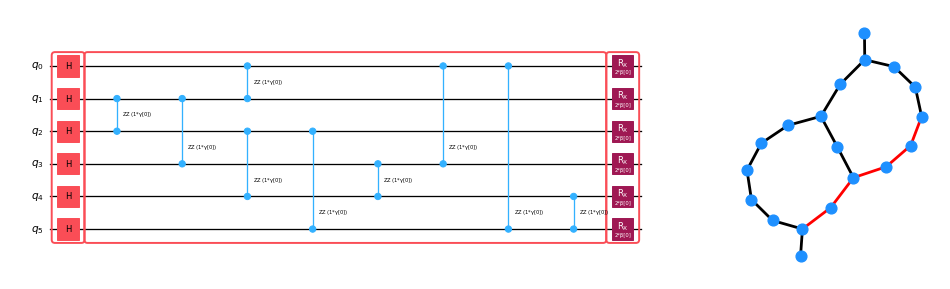

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3.5), gridspec_kw={'width_ratios': [3, 1]})

edge_set = [(path[i], path[i+1]) for i in range(len(path)-1)] + [(path[i+1], path[i]) for i in range(len(path)-1)]
ansatz.draw("mpl", fold=False, ax=axs[0])
cmapg = nx.from_edgelist(list(cmap.get_edges()))
nx.draw(cmapg, ax = axs[1], edge_color=["r" if edge in edge_set else "k" for edge in cmapg.edges()], width=2, node_color="dodgerblue", node_size=60)

Second, we run the QAOA pass manager. Note that before we run the QAOA pass manager we add measurements to all the qubits. This needs to be done before running the pass manager to ensure that the measurements are permuted with the SWAP gates.

In [9]:
initial_layout = Layout.from_intlist(path, ansatz.qregs[0])
qaoa_pm = generate_preset_qaoa_pass_manager(backend, swap_strat, initial_layout=initial_layout, edge_coloring=edge_coloring)

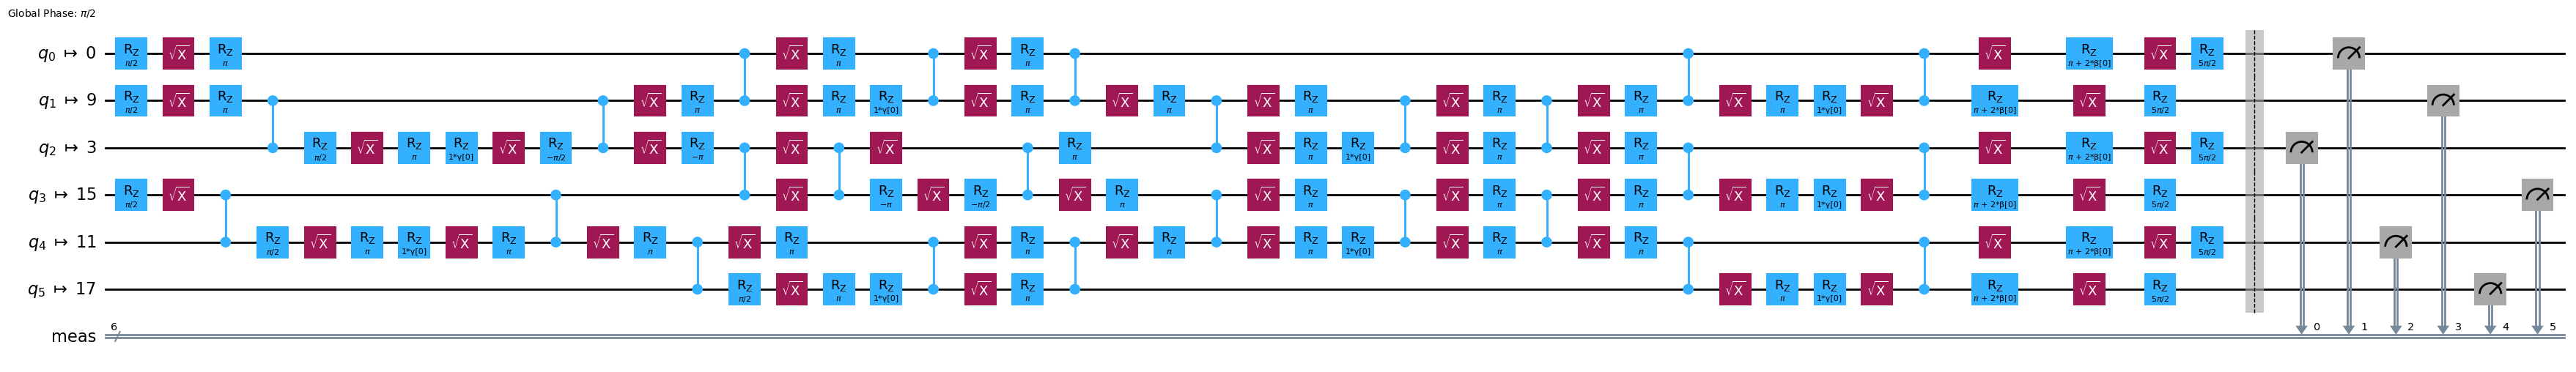

In [10]:
ansatz.measure_all()
isa_ansatz = qaoa_pm.run(ansatz)
isa_ansatz.draw("mpl", fold=False, wire_order=path + [idx for idx in range(backend.num_qubits) if idx not in path])